In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import MinMaxScaler
from array import array
from keras.utils import to_categorical
from keras.utils import np_utils
#from ann_visualizer.visualize import ann_viz
import config
import pandas as pd

In [7]:
# read row data
pci_train = np.genfromtxt('rem_pci_train.csv', delimiter=',')
#pci_train = np.genfromtxt('add_kmeans.csv', delimiter=',')
rsrp_train = np.genfromtxt('rem_rsrp_train.csv', delimiter=',')
data_test = np.genfromtxt('rem_test.csv', delimiter=',')



In [8]:
# select classifier and regressor
modelClassifier = KNeighborsClassifier(n_neighbors=3)
#modelClassifier = DecisionTreeClassifier()
#modelClassifier = MLPClassifier(hidden_layer_sizes=(300,), random_state=1, max_iter=1, warm_start=True)
#modelClassifier = MLPClassifier()

modelRegressor = KNeighborsRegressor(n_neighbors=3)
#modelRegressor = DecisionTreeRegressor()
# modelRegressor = RandomForestRegressor()
# modelRegressor = GradientBoostingRegressor()
#modelRegressor = MLPRegressor()
# modelRegressor = SVR()

In [9]:
# pci prediction
pci_pred = modelClassifier.fit(pci_train[:,0:-1], pci_train[:,-1]).predict(data_test[:,0:-2])
#pci_pred = modelClassifier.fit(pci_train[:,0:-1], pci_train[:,-1]).predict(data_test[:,0:-3])
#np.savetxt('pci_pred.csv', pci_pred, delimiter=',', fmt='%f')
n_accuracy = 0
for i in range(len(pci_pred)):
    if pci_pred[i] == data_test[i,-2]: 
        n_accuracy = n_accuracy+1
print ("n_accuracy_pci==",n_accuracy)
print ("len(pci_pred)==",len(pci_pred))
acc = n_accuracy/(len(pci_pred))
print('pci accuracy: ',acc )

n_accuracy_pci== 5495
len(pci_pred)== 5691
pci accuracy:  0.965559655596556


In [10]:
# rsrp range prediction
rsrp_pred = MultiOutputRegressor(modelRegressor).fit(rsrp_train[:,0:-3], rsrp_train[:,-3:-1]).predict(data_test[:,0:-1])
np.savetxt('rsrp_pred.csv', rsrp_pred, delimiter=',', fmt='%f')
#qq=np.zeros([len(rsrp_pred), 2])
n_accuracy = 0
for i in range(len(rsrp_pred)):
    #qq[i] = [rsrp_pred[i,1]-rsrp_pred[i,0]]
    if rsrp_pred[i,0] <= data_test[i,-1] and data_test[i,-1] <= rsrp_pred[i,1]: 
        n_accuracy = n_accuracy+1
print ("n_accuracy==",n_accuracy)
print ("len(rsrp_pred)==",len(rsrp_pred))
print('rsrp accuracy: ' + str(n_accuracy/len(rsrp_pred)))


print ("np.mean(qq)==",np.mean(rsrp_pred[:,1]-rsrp_pred[:,0]))
print ("np.mean(min)==",np.mean(rsrp_pred[:,0]))
print ("np.mean(max)==",np.mean(rsrp_pred[:,1]))


n_accuracy== 3892
len(rsrp_pred)== 5691
rsrp accuracy: 0.6838868388683886
np.mean(qq)== 6.916113161131611
np.mean(min)== -93.31862590054473
np.mean(max)== -86.4025127394131


In [11]:
# rsrp prediction
model_rsrp = modelRegressor
model_rsrp.fit(rsrp_train[:,0:-3], rsrp_train[:,-1]) 
rsrp_val = model_rsrp.predict(data_test[:,0:-1]) 
np.savetxt('rsrp_val.csv', rsrp_val, delimiter=',', fmt='%f')
RMSE = np.sqrt(np.square(np.subtract(data_test[:,-1], rsrp_val)).mean())
print('RSRP RMSE: ' + str(RMSE))

RSRP RMSE: 3.6267480514464907


In [12]:
def convert_location_data(x, y) :
    '''
    lng = a * x1 - b * y2 + c 
    lat = a * x2 + b * y1 + d

    NEMO -> indoor position value
    (840, -351) -> (96.824, 0)
    (923, -179) -> (107.068, 15.874)
    '''
    a = 0.1185
    b = -0.003
    c = -1.81
    d = 39.842
 
    lng = a * x - b * y * (-1) + c - 4
    lat = a * y * (-1) + b * x + d - 0.5

    return lng, lat

In [13]:
def cal_distance_to_cell (x_cell, y_cell, x_loc, y_loc) :
    dist = math.sqrt( (x_loc - x_cell)**2 + (y_loc - y_cell)**2 )
    #if x1>80:
    #    print "dist==",dist
    return dist

In [14]:
def cal_angle_to_cell (diff_x, diff_y) :
    radian = math.atan2(diff_y, diff_x)
    #print "radian==",radian
    degree = math.degrees(radian)
    #print "degree==",degree
    return degree

In [15]:
# radio map prediction
idx = 0
pci_map_test = np.zeros([26*106, data_test.shape[1]-2])
#pci_map_test = np.zeros([26*106, data_test.shape[1]-6])
#print ("146pci_map_test==",pci_map_test)
#map_feature = data_test[1,2:-6]
map_feature = data_test[1,2:-14]
#print "data_test[1,2:-6]==",data_test[1,2:-6]
#x1, y1 = convert_location_data (868, 199)
#x2, y2 = convert_location_data (735, 206)
x = np.zeros([6])
y = np.zeros([6])
x[0], y[0] = convert_location_data (260, 215)
x[1], y[1] = convert_location_data (480, 158)
x[2], y[2] = convert_location_data (630, 210)
x[3], y[3] = convert_location_data (710, 275)
x[4], y[4] = convert_location_data (765, 145)
x[5], y[5] = convert_location_data (908, 130)

print ("x[0], y[0]==",x[0], y[0])
print ("x[1], y[1]==",x[1], y[1])
print ("x[2], y[2]==",x[2], y[2])
print ("x[3], y[3]==",x[3], y[3])
print ("x[4], y[4]==",x[4], y[4])
print ("x[5], y[5]==",x[5], y[5])

pci_result = pd.read_csv("pci_result.csv")

cell = ['37','38','39','40','41','42']
dis = np.zeros([6])
ang = np.zeros([6])
for a in range(0, 106):
    for b in range(0, 26):
        xy = np.array([a, b], np.float)
        '''
        for i in range(0,6) : 
        #print "i==",i
            dis[i] = cal_distance_to_cell (x[i], y[i], xy[0], xy[1])
            ang[i] = cal_angle_to_cell (x[i]-xy[0], y[i]-xy[1])
        #print "dis[i]==",dis[i]
        #print "ang[i]==",ang[i]
        #ang[i] = cal_angle_to_cell (xy[0]-x1, xy[0]-y1)
        #ang[i] = cal_angle_to_cell (xy[0]-x2, xy[0]-y2)
            if 45<=ang[i]<90:
                ang[i]=1
            if 0<=ang[i]<45:
                ang[i]=2
            if -45<=ang[i]<0:
                ang[i]=3
            if -90<=ang[i]<-45:
                ang[i]=4
            if -135<=ang[i]<-90:
                ang[i]=5
            if -180<=ang[i]<-135:
                ang[i]=6
            if 135<=ang[i]<180:
                ang[i]=7
            if 90<=ang[i]<135:
                ang[i]=8
        #print "xy==",xy
        #print "xy.shape==",xy.shape
        #print "xy.ndim==",xy.ndim
        
        #if a==80 and b==18:
          #print "ang1==",ang1
          #print "ang2==",ang2
        
        #add_feature = np.append(add_feature,merge)
        #print "merge==",merge
        #add_feature = np.concatenate((add_feature,merge))
        #np.savetxt('add_feature.csv', add_feature, delimiter=',', fmt='%f')
        #add_feature = np.array(dis[6],dis[1],dis[2],dis[3],dis[4],dis[5],ang[6],ang[1],ang[2],ang[3],ang[4],ang[5])
        #print "add_feature==",add_feature
        '''
        #print "data_test.shape[1]==",data_test.shape[1]
        if data_test.shape[1] == 4:
            pci_map_test[idx,:] = xy
        else: 
           #pci_map_test[idx,:] = np.hstack((xy))
           #pci_map_test[idx,:] = np.hstack((xy,add_feature))
           #pci_map_test[idx,:] = np.hstack((xy, map_feature, add_feature))
            xy_dim = np.ndim(xy)
            merge_dim = np.ndim(merge)
           #print "xy_dim==",xy_dim
           #print "merge_dim==",merge_dim
            pci_map_test[idx,:] = np.hstack((pci_result))
           #pci_map_test[idx,:] = np.hstack((xy,map_feature,dis[1],dis[2],dis[3],dis[4],dis[5],dis[6],ang[1],ang[2],ang[3],ang[4],ang[5],ang[6]))
           #print "pci_map_test[idx,:]==",pci_map_test[idx,:]
        idx = idx+1
dis_np = np.array(dis)
ang_np = np.array(ang)
merge = np.concatenate((dis_np,ang_np))
np.savetxt('merge.csv', merge, delimiter=',', fmt='%f')
print('finish caculating')
#np.savetxt('dis_np.csv', dis_np, delimiter=',', fmt='%f')
#np.savetxt('ang_np.csv', ang_np, delimiter=',', fmt='%f')
np.savetxt('pci_map_test.csv', pci_map_test, delimiter=',', fmt='%f')
X = pci_train[:,0:-1]
Y = pci_train[:,-1]
print('finish select')
#X = rsrp_train[:,0:-3]
#Y = rsrp_train[:,-3]
#Y = np_utils.to_categorical(pci_train[:,-1])
np.savetxt('rsrp_train_x.csv', X, delimiter=',', fmt='%f')
np.savetxt('rsrp_train_y.csv', Y, delimiter=',', fmt='%f')
y_train = np.genfromtxt('rsrp_train_y.csv', delimiter=',')
a = np.array([])
'''
for i in range (len(y_train)):
    y_train_data = y_train[i]
    if y_train_data == 120:
       y_train_data = 1
    elif y_train_data == 151:
       y_train_data = 2
    elif y_train_data == 154:
       y_train_data = 3
    elif y_train_data == 301:
       y_train_data = 4
    elif y_train_data == 302:
       y_train_data = 5
    else:
       y_train_data = 0
       #print "pci is not in range"
    a = np.append(a,[y_train_data])
    np.savetxt('y_train_data.csv', a, delimiter=',', fmt='%f')

for i in range (len(y_train)):
    y_train_data = y_train[i]
    if y_train_data == 37:
        y_train_data = 1
    elif y_train_data == 38:
        y_train_data = 2
    elif y_train_data == 39:
        y_train_data = 3
    elif y_train_data == 40:
        y_train_data = 4
    elif y_train_data == 41:
        y_train_data = 5
    elif y_train_data == 42:
        y_train_data = 6
    else:
        y_train_data = 0
       #print "pci is not in range"
    a = np.append(a,[y_train_data])
    np.savetxt('y_train_data.csv', a, delimiter=',', fmt='%f')
print('finish')
y_train_input = np.genfromtxt('y_train_data.csv', delimiter=',')
np.savetxt('pci_train_Y.csv', y_train_input, delimiter=',', fmt='%f')
Y = np_utils.to_categorical(y_train_input)
'''

x[0], y[0]== 24.355 13.084499999999998
x[1], y[1]== 50.596 19.179
x[2], y[2]== 68.215 12.567
x[3], y[3]== 77.49999999999999 4.624499999999998
x[4], y[4]== 84.40749999999998 19.8645
x[5], y[5]== 101.398 21.213
finish caculating
finish select


'\nfor i in range (len(y_train)):\n    y_train_data = y_train[i]\n    if y_train_data == 120:\n       y_train_data = 1\n    elif y_train_data == 151:\n       y_train_data = 2\n    elif y_train_data == 154:\n       y_train_data = 3\n    elif y_train_data == 301:\n       y_train_data = 4\n    elif y_train_data == 302:\n       y_train_data = 5\n    else:\n       y_train_data = 0\n       #print "pci is not in range"\n    a = np.append(a,[y_train_data])\n    np.savetxt(\'y_train_data.csv\', a, delimiter=\',\', fmt=\'%f\')\n\nfor i in range (len(y_train)):\n    y_train_data = y_train[i]\n    if y_train_data == 37:\n        y_train_data = 1\n    elif y_train_data == 38:\n        y_train_data = 2\n    elif y_train_data == 39:\n        y_train_data = 3\n    elif y_train_data == 40:\n        y_train_data = 4\n    elif y_train_data == 41:\n        y_train_data = 5\n    elif y_train_data == 42:\n        y_train_data = 6\n    else:\n        y_train_data = 0\n       #print "pci is not in range"\n   

In [21]:
pci_map_pred = modelClassifier.fit(pci_train[:,0:-1], pci_train[:,-1]).predict(pci_map_test)
np.savetxt('pci_map_pred.csv', pci_map_pred, delimiter=',', fmt='%f')
pci_map_pred_np = np.array([pci_map_pred])
a_np = np.array([a])

#print "pci_map_pred_np[:2]==",pci_map_pred_np[:2]
np.savetxt('qq.csv', pci_map_pred_np, delimiter=',', fmt='%f')

rsrp_map_test = np.hstack((pci_map_test, pci_map_pred_np.T))
#print "323rsrp_map_test==",rsrp_map_test
#rsrp_map_test = np.hstack((pci_map_test, a_np.T))

rsrp_map_pred = model_rsrp.predict(rsrp_map_test) 
np.savetxt('rsrp_map_pred.csv', rsrp_map_pred, delimiter=',', fmt='%f')
rsrp_map_pred_np = np.array([rsrp_map_pred])
rsrp_map = np.hstack((pci_map_test, rsrp_map_pred_np.T))
pci_plot = np.zeros([26, 106])
rsrp_plot = np.zeros([26, 106])

for i in range(len(rsrp_map_test)): 
    this_w = int(rsrp_map_test[i,0])
    this_h = int(rsrp_map_test[i,1])
    pci_z = rsrp_map_test[i,-1]
    
    if pci_z == 37: 
        pci_plot[this_h, this_w] = 10
    elif pci_z == 38: 
        pci_plot[this_h, this_w] = 35
    elif pci_z == 39: 
        pci_plot[this_h, this_w] = 75
    elif pci_z == 40: 
        pci_plot[this_h, this_w] = 20
    elif pci_z == 41: 
        pci_plot[this_h, this_w] = 65
    elif pci_z == 42: 
        pci_plot[this_h, this_w] = 95
    elif pci_z == 120: 
        pci_plot[this_h, this_w] = 85
    elif pci_z == 154: 
        pci_plot[this_h, this_w] = 85
    elif pci_z == 151: 
        pci_plot[this_h, this_w] = 85
    else: 
        pci_plot[this_h, this_w] = 100

    rsrp_z = rsrp_map[i,-1]
    rsrp_plot[this_h, this_w] = rsrp_z   


In [17]:
def build_knn_model(X_train, y_train):
    print ("+++KNN")
    model =  KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    #model =  KNeighborsRegressor(n_neighbors=3, weights='uniform', algorithm='auto')
    model.fit(X_train, y_train)
    #print "y_train==",y_train
    return model

In [18]:
map_size = [105, 27]
x_resolution = map_size[0]
y_resolution = map_size[1]
merge_data = np.genfromtxt('pixel_pos.csv', delimiter=',')


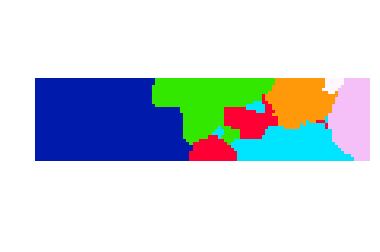

In [19]:
#output = modelClassifier.predict(xy)
output = modelClassifier.predict(merge_data)
np.savetxt('output.csv', output, delimiter=',', fmt='%f')
pci = []
    #Get the maxium output
    #for i in range(len(output)) :
    #    print output[i]
    #raw_input()
'''
for i in output :
    i = i.astype(np.float)
    max_idx = np.argmax((i))
    #print "max_idx==",max_idx
    if (i[max_idx] == 0.0) :
        pci.append(1)  # all pci probability is 0
    else :
        pci.append(max_idx)
'''
pci_input =  [37, 38, 39, 40, 41, 42, 120, 151, 154, 1, 62]
pci_config = np.array(pci_input)
f = open('pci_result.csv', 'w') #write the pci result into file
f.write('x,y,pci,\n')
#z = np.reshape(output, (y_resolution, x_resolution))
#z[:] = map(list,zip(*z[::-1]))
#z = np.genfromtxt('z.csv', delimiter=',')
#z_pred = np.hstack((xy, pci_map_pred))
output = output.reshape(27,105)
z = np.reshape(output, (y_resolution, x_resolution))
np.savetxt('z.csv', z, delimiter=',', fmt='%f')
for j in range(y_resolution):
        for i in range(x_resolution) : 
            pci = z[j][i]
            if pci == 37 :#37
                #pci_real = pci_config[0] 
                plt.plot(round(i), round(j), color='blue', marker = 's', markersize=5, alpha=.1)
            elif pci == 38 :#38
                #pci_real = pci_config[1]
                plt.plot(round(i), round(j), color='green', marker = 's', markersize=5, alpha=.1 )
            elif pci == 39 :#39
                #pci_real = pci_config[2]
                plt.plot(round(i), round(j), color='red', marker = 's', markersize=5, alpha=.1 )
            elif pci == 40:#40
                #pci_real = pci_config[3]
                plt.plot(round(i), round(j), color='skyblue', marker = 's', markersize=5, alpha=.1)
            elif pci == 41:#41
                #pci_real = pci_config[4]
                plt.plot(round(i), round(j), color='orange', marker = 's', markersize=5, alpha=.1)
            elif pci == 42:#42
                #pci_real = pci_config[5]
                plt.plot(round(i), round(j), color='deeppink', marker = 's', markersize=5, alpha=.1)
            elif pci == 120:#120
                #pci_real = pci_config[6]
                plt.plot(round(i), round(j), color='yellow', marker = 's', markersize=5, alpha=.1)
            elif pci == 151:#151
                #pci_real = pci_config[7]
                plt.plot(round(i), round(j), color='yellow', marker = 's', markersize=5, alpha=.1)
            elif pci == 154:#154
                #pci_real = pci_config[8]
                plt.plot(round(i), round(j), color='yellow', marker = 's', markersize=5, alpha=.1)
            else :                 
                pci_real = -1
                plt.plot(round(i), round(j), color='white', marker = 's', markersize=5, alpha=.1 )
            result = str(i) + ',' + str(j) + ',' + str(pci) +',' + '\n'
            f.write(result)  # python will convert \n to os.linesep

f.close()  # you can omit in most cases as the destructor will call it
img = plt.imread("./pic/51_5F-3.png")
plt.imshow(img, zorder=0, extent=[0, map_size[0], 0, map_size[1]])
x, y = convert_location_data (260,215) #37
plt.plot(round(abs(x)), round(abs(y)), color='blue', marker = 'o', markersize=10, markeredgecolor = 'black', markeredgewidth = 0.8)

#SC1 (199, 151)
#x, y = convert_location_data (199, 868)
x, y = convert_location_data (480, 158) #38
plt.plot(round(abs(x)), round(abs(y)), color='green', marker = 'o', markersize=10, markeredgecolor = 'black', markeredgewidth = 0.8)
    
x, y = convert_location_data (630, 210) #39
plt.plot(round(abs(x)), round(abs(y)), color='red', marker = 'o', markersize=10, markeredgecolor = 'black', markeredgewidth = 0.8)
#plt.plot(round(abs(x)), round(abs(y)), color='purple', marker = 'o', markersize=10, markeredgecolor = 'black', markeredgewidth = 0.8)
    
x, y = convert_location_data (710, 275) #40
plt.plot(round(abs(x)), round(abs(y)), color='skyblue', marker = 'o', markersize=10, markeredgecolor = 'black', markeredgewidth = 0.8)
    
x, y = convert_location_data (765, 145) #41
plt.plot(round(abs(x)), round(abs(y)), color='orange', marker = 'o', markersize=10, markeredgecolor = 'black', markeredgewidth = 0.8)
#plt.plot(round(abs(x)), round(abs(y)), color='red', marker = 'o', markersize=10, markeredgecolor = 'black', markeredgewidth = 0.8)

x, y = convert_location_data (908, 130) #42
plt.plot(round(abs(x)), round(abs(y)), color='deeppink', marker = 'o', markersize=10, markeredgecolor = 'black', markeredgewidth = 0.8)
plt.savefig('test', dpi=200)
plt.close('all')
fig_pci = plt.pcolor(pci_plot, vmin=1, vmax=100, cmap='gist_ncar')
#plt.colorbar(heatmap_pci)
#plt.axis([0, 35, 0, 25])
plt.axis('equal')
plt.axis('off')
plt.savefig('pci_map.png')
#plt.show()


ValueError: images do not match

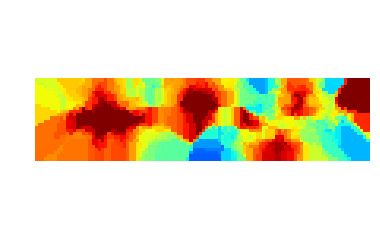

In [20]:
fig_rsrp = plt.pcolor(rsrp_plot, vmin=-130, vmax=-80, cmap='jet')
plt.axis('equal')
plt.axis('off')
plt.savefig('rsrp_map.png')

im_pci = Image.open('pci_map.png')
im_rsrp = Image.open('rsrp_map.png')

bk = Image.open('5f_map.png')
blended = Image.blend(im_pci, bk, alpha=0.4)
blended.save('5f_pci_map.png')
blended.show()

blended = Image.blend(im_rsrp, bk, alpha=0.4)
blended.save('5f_rsrp_map.png')
blended.show()

'''
for j in range(0,2835):
    for i in range(8,14):
        if 45<=merge_data[j][i]<90:
           merge_data[j][i]=1
        if 0<=merge_data[j][i]<45:
           merge_data[j][i]=2
        if -45<=merge_data[j][i]<0:
           merge_data[j][i]=3
        if -90<=merge_data[j][i]<-45:
           merge_data[j][i]=4
        if -135<=merge_data[j][i]<-90:
           merge_data[j][i]=5
        if -180<=merge_data[j][i]<-135:
           merge_data[j][i]=6
        if 135<=merge_data[j][i]<180:
           merge_data[j][i]=7
        if 90<=merge_data[j][i]<135:
           merge_data[j][i]=8
np.savetxt('pixel_pos_ang.csv', merge_data, delimiter=',', fmt='%f')
xy = np.genfromtxt('pixel_pos.csv', delimiter=',')
zero = np.zeros((2835,12))
merge = np.concatenate((xy,zero),axis=1)
'''